In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report, roc_curve
from sklearn.model_selection import RandomizedSearchCV

import numpy as np
from sklearn.metrics import roc_auc_score
import warnings
from sklearn.dummy import DummyClassifier
warnings.filterwarnings("ignore")

## 1 Get data & split into train/test/validation sets

In [2]:
df = pd.read_csv('./Data Exploration/wdbc.csv')
df = df.drop(["Area", "AreaSE", "AreaWorst","Perimeter", "PerimeterSE", "PerimeterWorst"], axis = 1)
encoder = LabelEncoder().fit(df["B/M"])
df['B/M'] = encoder.transform(df["B/M"])
not_data = ["ID", "B/M"]
label = df["B/M"]
feature = df.drop(not_data, axis = 1)
data = pd.concat([label, feature], axis=1)

##  1.1 Split into train / validation / test sets

In [3]:
x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=0.25, stratify=label, random_state=12)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train, random_state = 12)

## 2 Create & Train Initial Model

Our initial model that we train, before hyperparameter tuning. We want a higher Recall, as it accounts for false negatives - and gives us a lower proportion of them, which we desire. We get a very high accuracy and recall and precision - which makes me suspect of overfitting, especially because we have such a small sample size respective to the number of features.

In [4]:
def bench_marks(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')

rfc_og = RandomForestClassifier(n_estimators=100, oob_score=True, bootstrap=True, random_state=12)
rfc_og.fit(x_train, y_train)


print("Validation")
y_pred = rfc_og.predict(x_val)
bench_marks(y_val, y_pred)


Validation
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        67
           1       0.97      0.95      0.96        40

    accuracy                           0.97       107
   macro avg       0.97      0.97      0.97       107
weighted avg       0.97      0.97      0.97       107

[[66  1]
 [ 2 38]]
Accuracy: 0.9719626168224299
Recall: 0.95
Precision: 0.9743589743589743


## 3 Feature Selection
Determine importance of each feature, and use recursive feature elimination to determine how many of our features to keep. Then adjust our feature set.

In [5]:
feature_scores = pd.Series(rfc_og.feature_importances_, index=x_train.columns).sort_values(ascending=False)
print(feature_scores)
feature_scores = feature_scores.index.tolist()

ConcavePointsWorst       0.207396
RadiusWorst              0.152322
ConcavePoints            0.142657
Concavity                0.113919
ConcavityWorst           0.077798
Radius                   0.061077
Compactness              0.037406
CompactnessWorst         0.035937
RadiusSE                 0.028071
TextureWorst             0.017904
Texture                  0.017431
ConcavitySE              0.016186
ConcavePointsSE          0.013993
SymmetryWorst            0.010617
SmoothnessWorst          0.010396
FractalDimensionWorst    0.009966
FractalDimension         0.008799
TextureSE                0.008628
Smoothness               0.007033
FractalDimensionSE       0.006331
CompactnessSE            0.005240
SymmetrySE               0.004547
SmoothnessSE             0.003914
Symmetry                 0.002433
dtype: float64


To get a better of idea of how removing feature affects our result, we plot the graph of our OOB error against the number of features, which we remove accordingly to the previously established series of importance, in order. Done to both val and whole, maybe its okay tot est against whole set as OOB CV have something going on.

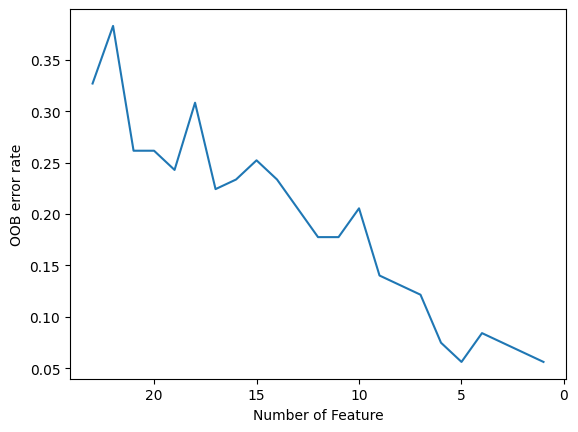

In [6]:
idx = []
error_rate = []
tempx = x_val
f_rm = 0
rfc_og = RandomForestClassifier(n_estimators=100, oob_score=True, bootstrap=True, random_state=12)

for i in feature_scores:
    rfc_og.fit(tempx, y_val)
    oob_error = 1 - rfc_og.oob_score_
    error_rate.append(oob_error)

    f_rm += 1
    idx.append(f_rm)

    tempx = tempx.drop(i, axis = 1)
    if len(tempx.columns) <= 1:
        break
plt.plot(idx, error_rate)
plt.xlabel("Number of Feature")
plt.ylabel("OOB error rate")
plt.gca().invert_xaxis()
plt.show()

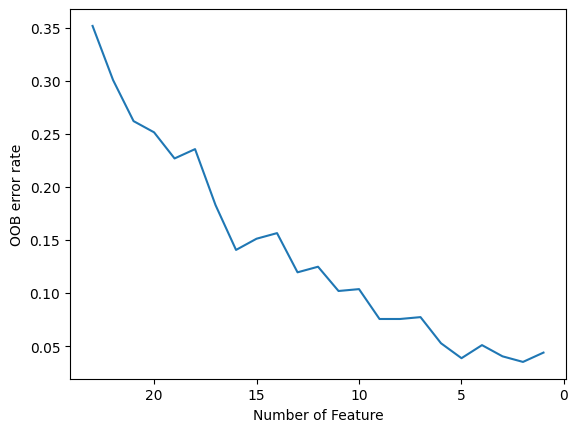

In [7]:
idx = []
error_rate = []
tempx = feature

f_rm = 0
for i in feature_scores:
    rfc_og.fit(tempx, label)
    oob_error = 1 - rfc_og.oob_score_
    error_rate.append(oob_error)

    f_rm += 1
    idx.append(f_rm)

    tempx = tempx.drop(i, axis = 1)
    if len(tempx.columns) <= 1:
        break

plt.plot(idx, error_rate)
plt.xlabel("Number of Feature")
plt.ylabel("OOB error rate")
plt.gca().invert_xaxis()
plt.show()

In [8]:
# Feature Elimination
rfecv = RFECV(estimator=rfc_og, step=1, cv=5,scoring='accuracy')
rfecv = rfecv.fit(x_train, y_train)
print("Removed n features:", rfecv.n_features_)
print(x_train.columns[rfecv.support_])
feature_select = feature[x_train.columns[rfecv.support_]]
# Redo sets as easier than dropping
x_train, x_test, y_train, y_test = train_test_split(feature_select, label, test_size=0.25, stratify=label, random_state=2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train, random_state=2)

Removed n features: 12
Index(['Radius', 'Compactness', 'Concavity', 'ConcavePoints', 'RadiusSE',
       'ConcavitySE', 'RadiusWorst', 'TextureWorst', 'CompactnessWorst',
       'ConcavityWorst', 'ConcavePointsWorst', 'SymmetryWorst'],
      dtype='object')


In [9]:
rfc_og.fit(x_train, y_train)

y_pred = rfc_og.predict(x_val)
bench_marks(y_val, y_pred)

y_pred_real = rfc_og.predict(x_test)
bench_marks(y_test, y_pred_real)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        67
           1       1.00      0.93      0.96        40

    accuracy                           0.97       107
   macro avg       0.98      0.96      0.97       107
weighted avg       0.97      0.97      0.97       107

[[67  0]
 [ 3 37]]
Accuracy: 0.9719626168224299
Recall: 0.925
Precision: 1.0
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        90
           1       0.94      0.83      0.88        53

    accuracy                           0.92       143
   macro avg       0.92      0.90      0.91       143
weighted avg       0.92      0.92      0.91       143

[[87  3]
 [ 9 44]]
Accuracy: 0.916083916083916
Recall: 0.8301886792452831
Precision: 0.9361702127659575


## 4 Hyperparameter Tuning

We will use a random grib with a randomized search to try different iterations of the trees and brute force our way to a optimal solution. We will repeat the code below, adjusting the parameters each iteration. Iterate by running this code while changing values in first box.

In [10]:
n_estimators = [300] #Usually more is better and reduce overfitting, but higher computational cost and diminishing returns after ~128
max_depth = [5, 6, 7,8, 9, 10, 11, 12,13, 14, 15, 16, 17] # Increase leads to increase in variance and decrease in bias
max_features = ["sqrt", "log2", None]
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_leaf = [1, 2, 3, 4, 5, 7]#Increase leads to increase in bias and decrease in variance
#bootstrap = [True, False] always true for oob
criterion=['gini', 'entropy']

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap,
               'criterion': criterion}

In [11]:
rf_random = RandomizedSearchCV(estimator = rfc_og, param_distributions = random_grid, n_iter = 200, cv = 3, verbose=2, n_jobs = -1)
rf_random.fit(x_train, y_train)
rfc_best = rf_random.best_estimator_

#ressults with validation set
y_pred = rfc_best.predict(x_val)
print(rf_random.best_estimator_)
print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'Recall: {recall_score(y_val, y_pred)}')
print(f'Precision: {precision_score(y_val, y_pred)}')
print("\n")

#results with actual test set
y_real_pred = rfc_best.predict(x_test)
print("For actual test set we get:")
print(f'Accuracy: {accuracy_score(y_test, y_real_pred)}')
print(f'Recall: {recall_score(y_test, y_real_pred)}')
print(f'Precision: {precision_score(y_test, y_real_pred)}')



Fitting 3 folds for each of 200 candidates, totalling 600 fits
RandomForestClassifier(criterion='entropy', max_depth=9, max_features=None,
                       min_samples_leaf=5, min_samples_split=3,
                       n_estimators=300, oob_score=True, random_state=12)
Accuracy: 0.9532710280373832
Recall: 0.925
Precision: 0.9487179487179487


For actual test set we get:
Accuracy: 0.9370629370629371
Recall: 0.8867924528301887
Precision: 0.94


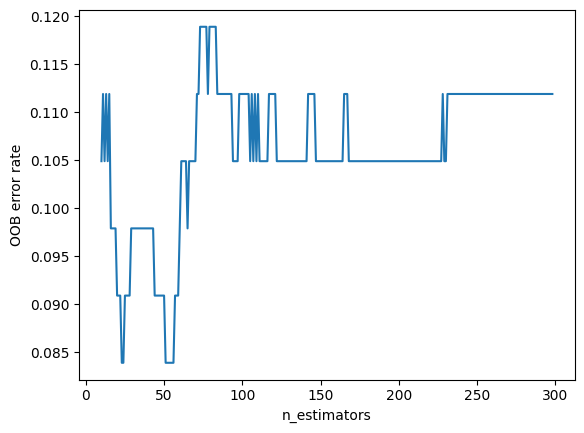

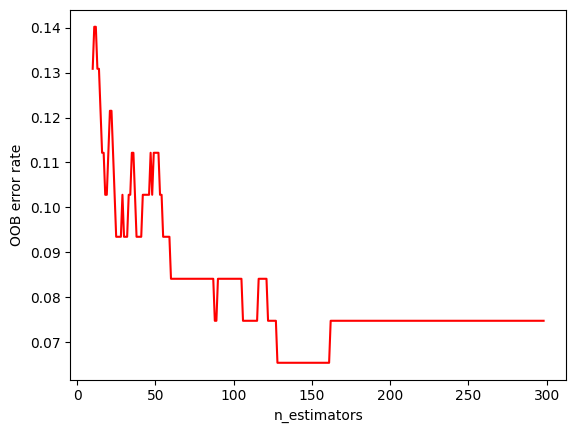

In [12]:
idx = []
idx2 = []

error_rate = []
error_rate_2 = []

min_estimators = 10
max_estimators = max(n_estimators)

for i in range(min_estimators, max_estimators - 1, 1):
    rfc_best.set_params(n_estimators=i)
    rfc_best.fit(x_test, y_test)
    oob_error = 1 - rfc_best.oob_score_
    idx.append(i)
    error_rate.append(oob_error)

for i in range(min_estimators, max_estimators - 1, 1):
    rfc_best.set_params(n_estimators=i)
    rfc_best.fit(x_val, y_val)
    oob_error = 1 - rfc_best.oob_score_
    idx2.append(i)
    error_rate_2.append(oob_error)


plt.plot(idx, error_rate)

plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show()

plt.plot(idx2, error_rate_2,"-r")
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show()

## 5 Test for over/ under fitting

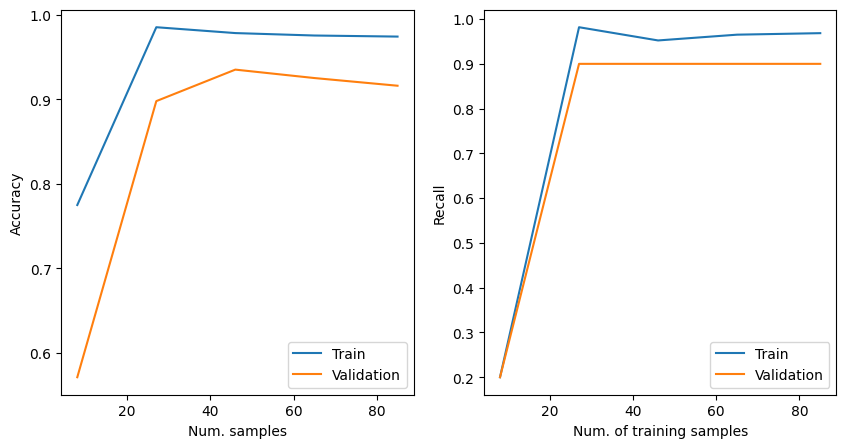

In [13]:
train_sizes_abs_accuracy, train_accuracy, test_accuracy = learning_curve(estimator=rfc_best, X=x_val, y=y_val, scoring='accuracy', cv=5, random_state=2)
train_sizes_abs_error, train_error, test_error = learning_curve(estimator=rfc_best, X=x_val, y=y_val, scoring='recall', cv=5, random_state=0)
train_avg_accuracy, test_avg_accuracy, train_avg_error, test_avg_error = [], [], [], []


for i in range(len(train_sizes_abs_accuracy)):
    train_avg_accuracy.append(np.average(train_accuracy[i]))
    test_avg_accuracy.append(np.average(test_accuracy[i]))

for i in range(len(train_sizes_abs_error)):
    train_avg_error.append(np.average(train_error[i]))
    test_avg_error.append(np.average(test_error[i]))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Accuracy learning curve
ax[0].plot(train_sizes_abs_accuracy, train_avg_accuracy)
ax[0].plot(train_sizes_abs_accuracy, test_avg_accuracy)
ax[0].legend(['Train', 'Validation'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Num. samples')

# Error learning curve
ax[1].plot(train_sizes_abs_error, train_avg_error)
ax[1].plot(train_sizes_abs_error, test_avg_error)
ax[1].legend(['Train', 'Validation'])
ax[1].set_xlabel('Num. of training samples')
ax[1].set_ylabel('Recall')
plt.show()

Could plot against test set, but best to do again validation as it shows us how our model changes.

The learning curve changes a lot each time. This may be because there isn't much relationship between the variables and label, but we used cross validation to get rid of this issue - another reason may be because our dataset is too small. There is a fairly large gap between my train and validation sets, so I increased the train/test/validation split as I feel the graph could trend towards a more accurate union between the two sets.

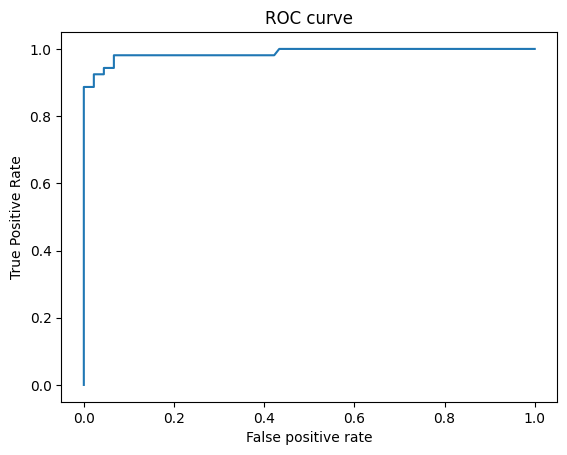

In [14]:
# After hyperparameter tuning* and feature selection*
y_real_pred = rfc_best.predict(x_test)
auc = roc_auc_score(y_test, y_real_pred)

y_pred_prob = rfc_best.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True Positive Rate')
plt.show()

In [15]:
for idx, metric in enumerate(list(zip(tpr, fpr, thresholds))[1::]):
    tpr_, fpr_, threshold =  metric[0], metric[1], metric[2]
    print(f'''
    TPR: {tpr_}
    FPR: {fpr_}
    threshold: {threshold}
    threshold_idx: {idx + 1}
    ''')


    TPR: 0.018867924528301886
    FPR: 0.0
    threshold: 1.0
    threshold_idx: 1
    

    TPR: 0.07547169811320754
    FPR: 0.0
    threshold: 0.9995805369127517
    threshold_idx: 2
    

    TPR: 0.16981132075471697
    FPR: 0.0
    threshold: 0.999440715883669
    threshold_idx: 3
    

    TPR: 0.4528301886792453
    FPR: 0.0
    threshold: 0.9487630471690878
    threshold_idx: 4
    

    TPR: 0.49056603773584906
    FPR: 0.0
    threshold: 0.9429616896898779
    threshold_idx: 5
    

    TPR: 0.8867924528301887
    FPR: 0.0
    threshold: 0.5357244550641712
    threshold_idx: 6
    

    TPR: 0.8867924528301887
    FPR: 0.022222222222222223
    threshold: 0.48876316636383754
    threshold_idx: 7
    

    TPR: 0.9245283018867925
    FPR: 0.022222222222222223
    threshold: 0.48263126749111773
    threshold_idx: 8
    

    TPR: 0.9245283018867925
    FPR: 0.044444444444444446
    threshold: 0.4560276785109001
    threshold_idx: 9
    

    TPR: 0.9433962264150944
    FPR: 0.

We want to minimise false positives..

How does this graph help us? IG I could manually calculate (using the graph) the precesion, accuracy and  recall stats to determine which point is best.

In [16]:
dm = DummyClassifier()
dm.fit(x_train, y_train)
dummy_score = dm.score(x_test, y_test)
y_pred = rfc_best.predict(x_test)  # Model classifications
accuracy = accuracy_score(y_test, y_pred)

print(f'{"Our model beats the dummy model" if accuracy > dummy_score else "Our model does not beat the dummy model."}')

Our model beats the dummy model


In [17]:
print(classification_report(y_test, y_real_pred))
c = confusion_matrix(y_test, y_pred_real)
print(f'True negatives: {c[0][0]}')
print(f'False negatives: {c[1][0]}')
print(f'True positives: {c[1][1]}')
print(f'False positives: {c[0][1]}')

              precision    recall  f1-score   support

           0       0.94      0.99      0.96        90
           1       0.98      0.89      0.93        53

    accuracy                           0.95       143
   macro avg       0.96      0.94      0.95       143
weighted avg       0.95      0.95      0.95       143

True negatives: 87
False negatives: 9
True positives: 44
False positives: 3
